In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast

df = pd.read_csv('founders_dataset.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (1209, 25)


,roles,preferred_role,industry,secondary_industries,years_of_experience,is_technical,education_level,tech_stack,strengths,weaknesses,idea_title,idea_description,problem_space,founder_id,age,gender,collaboration_openness_score,communication_intensity_score,responsiveness_score,risk_tolerance,leadership,autonomy,vision,communication,execution_speed
0,"[""COO""]",COO,Other,[],4,False,bachelor,"[""Swift"", ""Node.js""]","[""User empathy"", ""Communication skills"", ""Anal...","[""Risk-averse"", ""Impatient with slow processes""]",Sustainable Urban Mobility Solutions,Develop a platform that connects urban dweller...,Urban areas are increasingly congested and pol...,0a5e3dd8489fe67485ddb7d6adb26ebd,21,M,0.036290,0.024107,0.143475,2,2,3,3,3,4
1,"[""CEO""]",CEO,Gaming / Entertainment,[],7,True,self-taught,"[""Unity"", ""C#"", ""JavaScript"", ""Webflow""]","[""User empathy"", ""Team-building"", ""Creativity ...","[""Poor work-life balance"", ""Limited business e...",Interactive Storytelling Platform,An innovative platform that allows users to cr...,Traditional storytelling methods often lack in...,10a8c197447a3991d64136b315d6e87e,19,M,0.031654,0.010418,0.177019,4,2,3,4,5,5
2,"[""CEO""]",CEO,Consumer / Social,[],3,False,bachelor,"[""React"", ""Node.js"", ""Firebase""]","[""Creativity and vision"", ""High ownership"", ""P...","[""Overly detail-oriented"", ""Weak in sales""]",Social Connection Platform,A platform designed to foster genuine connecti...,"In an era of digital communication, many indiv...",048dd37565ad9cbc24c163ffedffbf58,21,M,0.022029,0.003984,0.092243,4,5,4,3,5,3
3,"[""COO""]",COO,Fintech,[],12,False,master,"[""Figma"", ""Swift"", ""Notion"", ""AWS""]","[""High ownership"", ""Resilience"", ""Fast executi...","[""Overly optimistic"", ""Easily distracted by ne...",Fintech Innovation Project,Develop a platform that simplifies the loan ap...,Many young entrepreneurs struggle to secure fu...,024610702baf540af5637873cd1534e9,19,M,0.277378,0.036848,0.127754,4,2,2,4,4,5
4,"[""CTO""]",CTO,Other,[],2,True,bachelor,"[""AWS"", ""Django"", ""Swift"", ""Docker""]","[""Resilience"", ""Scrappiness"", ""Strong leadersh...","[""Overly detail-oriented"", ""Poor work-life bal...",Intelligent Recipe Manager,An app that uses AI to suggest recipes based o...,Many people struggle with meal planning and of...,2057ea510896a025db5790675c90b7d6,19,M,0.195837,0.125118,0.038137,4,3,3,2,4,3


## **Data preprocessing**

Before clustering, we need to convert all features into numerical format. This involves:

1. **Multi-label encoding**: Convert list-like columns (roles, tech_stack, etc.) to binary features
2. **Categorical encoding**: One-hot encode single-value categorical features
3. **Numeric scaling**: Standardize numerical features

In [2]:
# Define column types
multi_label_cols = [
    'roles',
    'secondary_industries', 
    'tech_stack',
    'strengths',
    'weaknesses'
]

text_cols = [
    'idea_title',
    'idea_description', 
    'problem_space'
]

categorical_cols = [
    'preferred_role',
    'industry',
    'education_level',
    'gender',
    'is_technical'
]

numeric_cols = [
    'years_of_experience',
    'age',
    'collaboration_openness_score',
    'communication_intensity_score',
    'responsiveness_score',
    'risk_tolerance',
    'leadership',
    'autonomy',
    'vision',
    'communication',
    'execution_speed'
]


Convert string representations of lists into actual Python lists for processing.

In [3]:
# Convert list-like strings to actual lists
for col in multi_label_cols:
    df[col] = df[col].fillna('[]').apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Display sample of parsed data
print("Sample of parsed multi-label columns:")
df[multi_label_cols].head(3)

Sample of parsed multi-label columns:


,roles,secondary_industries,tech_stack,strengths,weaknesses
0,[COO],[],"[Swift, Node.js]","[User empathy, Communication skills, Analytica...","[Risk-averse, Impatient with slow processes]"
1,[CEO],[],"[Unity, C#, JavaScript, Webflow]","[User empathy, Team-building, Creativity and v...","[Poor work-life balance, Limited business expe..."
2,[CEO],[],"[React, Node.js, Firebase]","[Creativity and vision, High ownership, Produc...","[Overly detail-oriented, Weak in sales]"


Convert multi-label columns into binary feature vectors using MultiLabelBinarizer.

In [4]:
from sklearn.preprocessing import MultiLabelBinarizer

# Process each multi-label column
mlb_features = {}
for col in multi_label_cols:
    mlb = MultiLabelBinarizer()
    mlb_features[col] = mlb.fit_transform(df[col])
    print(f"{col}: {mlb_features[col].shape[1]} unique values")

# Show total binary features created
total_mlb_features = sum(feat.shape[1] for feat in mlb_features.values())
print(f"Total multi-label binary features: {total_mlb_features}")

roles: 4 unique values
secondary_industries: 1 unique values
tech_stack: 75 unique values
strengths: 14 unique values
weaknesses: 14 unique values
Total multi-label binary features: 108


Use scikit-learn's ColumnTransformer to process categorical and numeric features together.

In [5]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Create preprocessing pipeline
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", StandardScaler(), numeric_cols),
    ]
)

# Fit and transform the structured features
X_structured = preprocess.fit_transform(df)

print(f"Structured features shape: {X_structured.shape}")

Structured features shape: (1209, 37)


Merge all feature types into a single feature matrix for clustering.

In [6]:
# Combine all features: structured + multi-label (no text embeddings)
X = np.hstack([
    X_structured,
    *[mlb_features[col] for col in multi_label_cols]
])

print(f"Final feature matrix shape: {X.shape}")
print(f"Total features per founder: {X.shape[1]}")

Final feature matrix shape: (1209, 145)
Total features per founder: 145


## **Dimensionality reduction with PCA**

Since we have many features, we'll use Principal Component Analysis (PCA) to reduce dimensionality while retaining most of the variance. This helps:
- Speed up clustering algorithms
- Reduce noise in the data
- Avoid curse of dimensionality

## **Complementarity clustering**

We will produce a complementarity-based clustering (group complementary founders together using graph-based affinity)

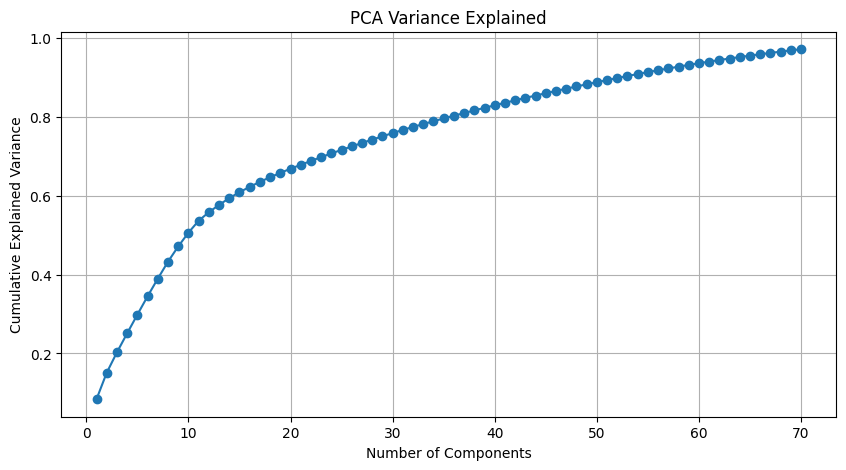

Reduced feature matrix shape: (1209, 70)
Optimal number of PCA components for 90% variance: 53


In [7]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensions
n_components = 70
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

# Show variance explained
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot variance explained
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_components + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Variance Explained')
plt.grid(True)
plt.show()

print(f"Reduced feature matrix shape: {X_pca.shape}")

# choose optimal number of PCA components based on variance explained plot >= 0.9
n_components = cumulative_variance.searchsorted(0.9) + 1
print(f"Optimal number of PCA components for 90% variance: {n_components}")

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

# KMeans clustering

Before clustering, we construct a complementarity affinity matrix based on role differences, tech diversity, and strengths-weaknesses coverage.

In [8]:
import numpy as np
import pandas as pd

def jaccard_similarity(list_a, list_b):
    a = set(list_a or [])
    b = set(list_b or [])
    if not a and not b:
        return 1.0
    return len(a & b) / len(a | b)

def jaccard_diversity(list_a, list_b):
    return 1.0 - jaccard_similarity(list_a, list_b)

def strengths_weaknesses_complement(s_a, w_a, s_b, w_b):
    s_a, w_a = set(s_a or []), set(w_a or [])
    s_b, w_b = set(s_b or []), set(w_b or [])
    a_covers = len(s_a & w_b)
    b_covers = len(s_b & w_a)
    max_possible = max(1, len(w_a) + len(w_b))
    return (a_covers + b_covers) / max_possible


def build_complementarity_matrix(df):
    n = len(df)
    comp_aff = np.zeros((n, n), dtype=float)

    for i in range(n):
        for j in range(i + 1, n):
            role_diff = float(df['preferred_role'].iloc[i] != df['preferred_role'].iloc[j])
            roles_div = jaccard_diversity(df['roles'].iloc[i], df['roles'].iloc[j])
            tech_div = jaccard_diversity(df['tech_stack'].iloc[i], df['tech_stack'].iloc[j])
            sw_comp = strengths_weaknesses_complement(
                df['strengths'].iloc[i], df['weaknesses'].iloc[i],
                df['strengths'].iloc[j], df['weaknesses'].iloc[j]
            )
            score = 0.35 * role_diff + 0.30 * roles_div + 0.20 * tech_div + 0.15 * sw_comp
            comp_aff[i, j] = comp_aff[j, i] = score

    return comp_aff

comp_affinity = build_complementarity_matrix(df)
print(f"Complementarity affinity matrix shape: {comp_affinity.shape}")


Complementarity affinity matrix shape: (1209, 1209)


## **KMeans**

Determine optimal number of clusters with elbow method

K=2, Inertia: 22501.683009037075
K=3, Inertia: 21397.91472202024
K=4, Inertia: 20752.39934388506
K=5, Inertia: 20079.334325344877
K=6, Inertia: 19609.65792347169
K=7, Inertia: 19430.08339778683
K=8, Inertia: 18943.12152316142
K=9, Inertia: 18743.729677109557
K=10, Inertia: 18279.738261837367


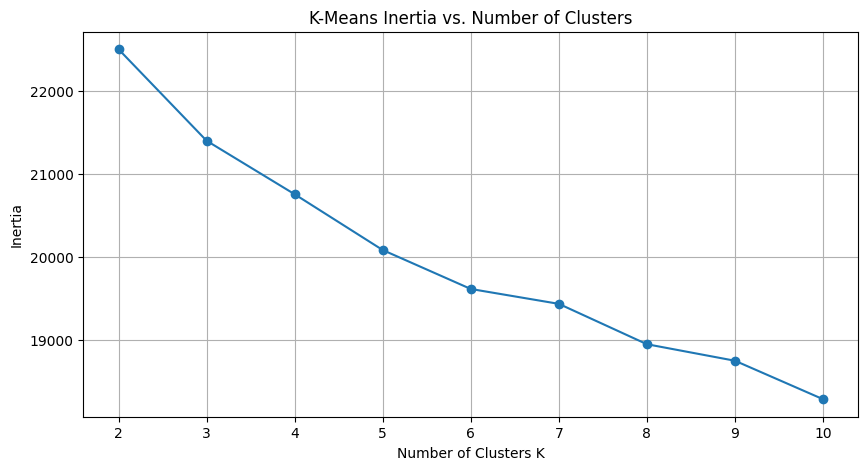

In [9]:
from sklearn.cluster import KMeans

k_range = range(2, 11)
kmeans_models = {}
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    kmeans_models[k] = kmeans
    print(f"K={k}, Inertia: {kmeans.inertia_}")

plt.figure(figsize=(10, 5))
inertias = [kmeans_models[k].inertia_ for k in k_range]
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of Clusters K')
plt.ylabel('Inertia')
plt.title('K-Means Inertia vs. Number of Clusters')
plt.grid(True)

In [22]:
n_clusters = 6

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters_comp = kmeans.fit_predict(X_pca)

# Add labels
df['cluster_complementarity'] = clusters_comp
print("KMeans-based cluster sizes:")
print(df['cluster_complementarity'].value_counts().sort_index())

KMeans-based cluster sizes:
cluster_complementarity
0     27
1    295
2    315
3    241
4    175
5    156
Name: count, dtype: int64


We compute a pairwise complementarity score between founders (role difference, tech diversity, and strengths covering weaknesses) and summarize within-cluster complementarity for KMeans clustering.

In [23]:
def cluster_complementarity_summary(labels, comp_aff):
    labels = np.asarray(labels)
    cluster_ids = sorted(set(labels))
    results = []
    total_pairs = 0
    total_sum = 0.0
    for cid in cluster_ids:
        idx = np.where(labels == cid)[0]
        if len(idx) < 2:
            mean_comp = float('nan')
            pair_count = 0
        else:
            sub = comp_aff[np.ix_(idx, idx)]
            tri = sub[np.triu_indices_from(sub, k=1)]
            pair_count = len(tri)
            mean_comp = float(tri.mean()) if pair_count > 0 else float('nan')
        results.append((cid, len(idx), pair_count, mean_comp))
        if pair_count > 0 and not np.isnan(mean_comp):
            total_pairs += pair_count
            total_sum += tri.sum()
    overall_mean = (total_sum / total_pairs) if total_pairs > 0 else float('nan')
    return results, overall_mean

# Evaluate KMeans clustering complementarity
kmeans_results, kmeans_overall = cluster_complementarity_summary(df['cluster_complementarity'], comp_affinity)
print("KMeans Clustering Complementarity (within clusters):")
for cid, size, pairs, mean_comp in kmeans_results:
    print(f"Cluster {cid}: size={size}, pairs={pairs}, mean_comp={mean_comp:.3f}")
print(f"Overall (pair-weighted) mean complementarity: {kmeans_overall:.3f}")


KMeans Clustering Complementarity (within clusters):
Cluster 0: size=27, pairs=351, mean_comp=0.675
Cluster 1: size=295, pairs=43365, mean_comp=0.626
Cluster 2: size=315, pairs=49455, mean_comp=0.613
Cluster 3: size=241, pairs=28920, mean_comp=0.642
Cluster 4: size=175, pairs=15225, mean_comp=0.653
Cluster 5: size=156, pairs=12090, mean_comp=0.638
Overall (pair-weighted) mean complementarity: 0.629


In [24]:
# Analyze numeric features by complementarity cluster
numeric_analysis = df.groupby('cluster_complementarity')[numeric_cols].mean()
print("Average numeric features by complementarity cluster:")
print(numeric_analysis.round(2))

Average numeric features by complementarity cluster:
                         years_of_experience  ...  execution_speed
cluster_complementarity                       ...                 
0                                       4.52  ...             3.33
1                                       3.93  ...             3.59
2                                       3.61  ...             3.58
3                                       4.25  ...             3.56
4                                       9.03  ...             3.62
5                                       4.50  ...             3.35

[6 rows x 11 columns]


In [25]:
# Analyze categorical features by complementarity clusters
print("CLUSTER PROFILES - CATEGORICAL FEATURES (Complementarity)")

for cluster_id in sorted(df['cluster_complementarity'].unique()):
    cluster_data = df[df['cluster_complementarity'] == cluster_id]
    print(f"CLUSTER {cluster_id} (n={len(cluster_data)} founders)")
    
    # Most common categorical values
    print("Preferred Roles:")
    print(cluster_data['preferred_role'].value_counts().head())
    
    print("Industries:")
    print(cluster_data['industry'].value_counts().head())
    
    print("Education Levels:")
    print(cluster_data['education_level'].value_counts().head())
    
    print("Gender Distribution:")
    print(cluster_data['gender'].value_counts())

    print("="*80)

CLUSTER PROFILES - CATEGORICAL FEATURES (Complementarity)
CLUSTER 0 (n=27 founders)
Preferred Roles:
preferred_role
CTO    9
CEO    8
COO    5
CPO    5
Name: count, dtype: int64
Industries:
industry
Marketplaces           4
E-commerce             3
Climate / Greentech    3
Edtech                 3
Healthtech             2
Name: count, dtype: int64
Education Levels:
education_level
bachelor       10
bootcamp        7
master          5
self-taught     5
Name: count, dtype: int64
Gender Distribution:
gender
M    23
F     4
Name: count, dtype: int64
CLUSTER 1 (n=295 founders)
Preferred Roles:
preferred_role
CEO    145
CTO     63
CPO     47
COO     40
Name: count, dtype: int64
Industries:
industry
AI / Deeptech        33
Marketplaces         29
Consumer / Social    29
Web3 / Crypto        24
SaaS                 23
Name: count, dtype: int64
Education Levels:
education_level
bachelor       96
bootcamp       73
self-taught    58
master         56
phd            12
Name: count, dtype: int64
Ge

In [26]:
# Analyze multi-label features (most common values in each cluster)
print("CLUSTER PROFILES - MULTI-LABEL FEATURES")

for cluster_id in sorted(df['cluster_complementarity'].unique()):
    cluster_data = df[df['cluster_complementarity'] == cluster_id]
    print(f"CLUSTER {cluster_id}")
    
    # Flatten lists and count occurrences
    for col in ['roles', 'tech_stack', 'strengths', 'weaknesses']:
        all_values = [item for sublist in cluster_data[col] for item in sublist]
        if all_values:
            value_counts = pd.Series(all_values).value_counts().head(5)
            print(f"Top {col}:")
            print(value_counts)

    print(f"{'='*80}")


CLUSTER PROFILES - MULTI-LABEL FEATURES
CLUSTER 0
Top roles:
CTO    9
CEO    8
COO    7
CPO    7
Name: count, dtype: int64
Top tech_stack:
Python     11
Webflow     7
Figma       6
Docker      5
Swift       5
Name: count, dtype: int64
Top strengths:
Creativity and vision    15
Scrappiness              11
Team-building             8
User empathy              7
Strategic thinking        7
Name: count, dtype: int64
Top weaknesses:
Difficulty delegating            7
Impatient with slow processes    7
Lack of focus                    5
Limited technical experience     5
Struggles with prioritization    4
Name: count, dtype: int64
CLUSTER 1
Top roles:
CEO    146
CTO     84
CPO     75
COO     48
Name: count, dtype: int64
Top tech_stack:
Python        89
React         73
Node.js       69
AWS           63
PostgreSQL    54
Name: count, dtype: int64
Top strengths:
Creativity and vision    88
User empathy             82
Strong leadership        79
Scrappiness              65
High ownership        

## **Complementarity evaluation**

In [27]:
def top_complementary_pairs(labels, comp_aff, top_n=5):
    labels = np.asarray(labels)
    results = {}
    for cid in sorted(set(labels)):
        idx = np.where(labels == cid)[0]
        pairs = []
        if len(idx) >= 2:
            sub = comp_aff[np.ix_(idx, idx)]
            for a in range(len(idx)):
                for b in range(a+1, len(idx)):
                    i, j = idx[a], idx[b]
                    pairs.append((i, j, sub[a, b]))
            pairs.sort(key=lambda x: x[2], reverse=True)
            results[cid] = pairs[:top_n]
        else:
            results[cid] = []
    return results

def print_pair_examples(title, pairs_dict):
    print(f"{title}")
    for cid in sorted(pairs_dict.keys()):
        print(f"Cluster {cid} - Top Complementary Pairs")
        cluster_pairs = pairs_dict[cid]
        if not cluster_pairs:
            print("No pairs available (cluster size < 2)")
            continue
        for (i, j, score) in cluster_pairs:
            row_i = df.iloc[i]
            row_j = df.iloc[j]
            role_i = row_i['preferred_role']
            role_j = row_j['preferred_role']
            tech_i = row_i['tech_stack'] or []
            tech_j = row_j['tech_stack'] or []
            strengths_i = row_i['strengths'] or []
            strengths_j = row_j['strengths'] or []
            weaknesses_i = row_i['weaknesses'] or []
            weaknesses_j = row_j['weaknesses'] or []
            role_diff = 1.0 if role_i != role_j else 0.0
            tech_diversity = 1 - jaccard_similarity(tech_i, tech_j)
            sw_comp = strengths_weaknesses_complement(strengths_i, weaknesses_i, strengths_j, weaknesses_j)
            print(f"Pair: Founder {row_i['founder_id']} ↔ Founder {row_j['founder_id']}")
            print(f"  Complementarity Score: {score:.3f} | RoleDiff: {role_diff:.1f} | TechDiv: {tech_diversity:.2f} | S↔W: {sw_comp:.2f}")
            print(f"  Roles: {role_i} ↔ {role_j}")
            print(f"  Tech (samples): {', '.join(tech_i[:3]) if tech_i else 'None'} ↔ {', '.join(tech_j[:3]) if tech_j else 'None'}")
            print(f"  Strengths (samples): {', '.join(strengths_i[:2]) if strengths_i else 'None'} ↔ {', '.join(strengths_j[:2]) if strengths_j else 'None'}")

    print(f"{'='*80}")


In [ ]:
# Top pairs for KMeans clusters
pairs_kmeans = top_complementary_pairs(clusters_comp, comp_affinity, top_n=5)
print_pair_examples("KMeans - Top Complementary Pairs", pairs_kmeans)

Spectral - Top Complementary Pairs
Cluster 0 - Top Complementary Pairs
Pair: Founder 53f6bdb7eeb0c0eedf8dbf5c271ff887 ↔ Founder cef50ce50692bb1260ae383c8e2a029c
  Complementarity Score: 0.850 | RoleDiff: 1.0 | TechDiv: 1.00 | S↔W: 0.00
  Roles: CTO ↔ CEO
  Tech (samples): MongoDB, PostgreSQL, AWS ↔ Figma, Slack, Trello
  Strengths (samples): Creativity and vision, Ability to learn quickly ↔ Strong leadership, User empathy
Pair: Founder 53f6bdb7eeb0c0eedf8dbf5c271ff887 ↔ Founder 160dae1bf017f6109584bc5d11595428
  Complementarity Score: 0.850 | RoleDiff: 1.0 | TechDiv: 1.00 | S↔W: 0.00
  Roles: CTO ↔ COO
  Tech (samples): MongoDB, PostgreSQL, AWS ↔ Excel, Google Analytics
  Strengths (samples): Creativity and vision, Ability to learn quickly ↔ Strong leadership, Creativity and vision
Pair: Founder 53f6bdb7eeb0c0eedf8dbf5c271ff887 ↔ Founder 2f051007e7936f333b5a19bab9f9d5c4
  Complementarity Score: 0.850 | RoleDiff: 1.0 | TechDiv: 1.00 | S↔W: 0.00
  Roles: CTO ↔ CPO
  Tech (samples): Mongo